In [19]:
import os
from pathlib import Path
from cotnav.dataset.dataset_helpers import get_mission_id
from cotnav.geometry.camera import (project_to_pixel)
from cotnav.utils.loader_utils import (load_intrinsics, load_odom, load_timestamps, build_transforms)
from cotnav.utils.math_utils import (interpolate_se3, odom_to_local_pose, transform_poses, se3_matrix)
from cotnav.utils.image_utils import (save_video)
from dotenv import load_dotenv
from decord import VideoReader
from decord import cpu, gpu
import numpy as np
import matplotlib.pyplot as plt

load_dotenv()

True

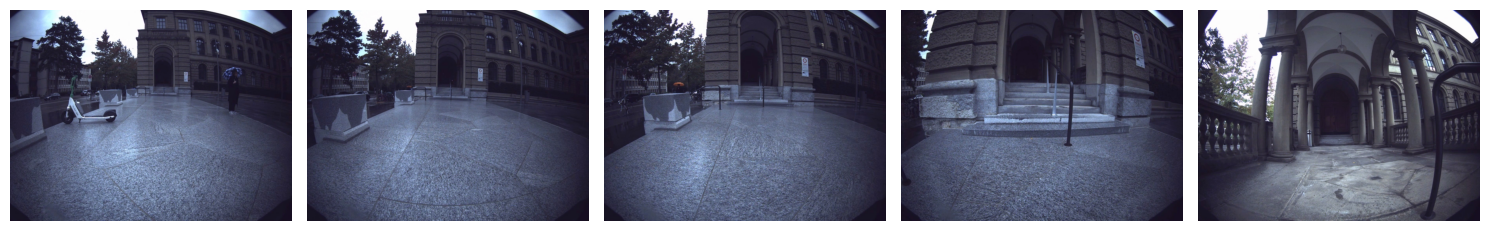

In [ ]:
%matplotlib inline
mission_dir = Path("/robodata/arthurz/Research/cotnav/data/grandtour_raw/mission_2024-10-01-12-00-49")
video_path = mission_dir / "front_camera_lossy.mp4"
ts_path   = mission_dir / "front_camera_timestamps_anymal.csv"
odom_path = mission_dir / "odometry_data_anymal.csv"
info_path = mission_dir / "front_camera_info_anymal.yaml"
tf_path = mission_dir / "tf_static_anymal.yaml"
START_FRAME = 1130
END_FRAME = 1430
FRAME_STEP = 1

assert all(p.exists() for p in [mission_dir, video_path, odom_path, info_path, ts_path, tf_path]), "One or more paths do not exist"

vr = VideoReader(str(video_path), ctx=cpu(0))
batch = vr.get_batch(np.arange(START_FRAME, END_FRAME, FRAME_STEP))
frames = batch.asnumpy()

plt.figure(figsize=(15, 6))
num_plots = 5
frame_indices = np.linspace(0, len(frames) - 1, num_plots, dtype=int)
for i, idx in enumerate(frame_indices):
    plt.subplot(1, num_plots, i + 1)
    plt.imshow(frames[idx])
    plt.axis('off')
plt.tight_layout()
plt.show()

# Write batch to video file
save_video(frames, "test_output.mp4", fps=10)


In [21]:
odom = load_odom(odom_path)

calib = load_intrinsics(info_path, tf_path, world_frame="base")
cam_ts = load_timestamps(ts_path)
interp_odom = interpolate_se3(cam_ts, odom[:, 0], odom[:, 1:4], odom[:, 4:8])

print("Loaded odometry with shape:", odom.shape)
print("Loaded timestamps with shape:", cam_ts.shape)
print("Interpolated odometry shape:", interp_odom.shape)

print("Image shape (H, W):", calib.size_hw)
print("Intrinsics:\n", calib.K)
print("TF world to cam:\n", calib.T_world_cam)

Loaded odometry with shape: (4764, 8)
Loaded timestamps with shape: (4775,)
Interpolated odometry shape: (4775, 8)
Image shape (H, W): (1080, 1440)
Intrinsics:
 [[700.38943503   0.         682.88965131]
 [  0.         700.13138396 523.1354161 ]
 [  0.           0.           1.        ]]
TF world to cam:
 [[-2.03673102e-04 -9.99999556e-01 -9.19946282e-04  1.01805505e-02]
 [-1.72922519e-01  9.41307357e-04 -9.84934981e-01  2.86088419e-01]
 [ 9.84935410e-01 -4.15253346e-05 -1.72922634e-01 -4.01986356e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


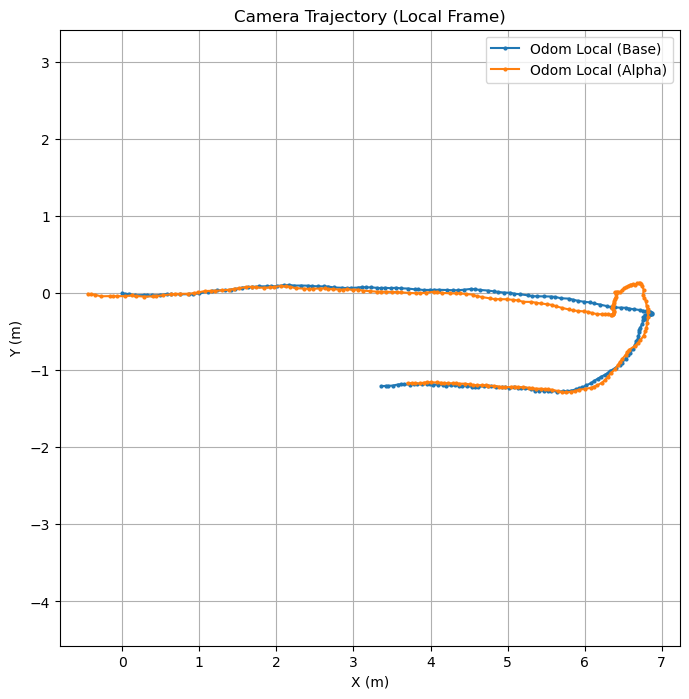

p_alpha_local shape  (200, 3)


In [22]:
tm = build_transforms(tf_path)

odom_window = odom[START_FRAME:END_FRAME]
T_hesai_odom = se3_matrix(odom_window[:, 1:4], odom_window[:, 4:8])
T_base_hesai = tm.get_transform("hesai_lidar", "base") # tgt, src
T_base_odom = T_hesai_odom @ T_base_hesai
T_base_local = np.linalg.inv(T_base_odom[0]) @ T_base_odom
p_base_local = T_base_local[:, :3, 3]

T_alpha_base = tm.get_transform("base", "alphasense_front_center") # tgt, src

p_alpha_base = -T_alpha_base[:3, 3]
p_alpha_base_homo = np.hstack((p_alpha_base, 1))
p_alpha_local = T_base_local @ p_alpha_base_homo.T
p_alpha_local = p_alpha_local[:, :3]

# Transform odom poses from world to local frame (base)
# plot odom and interpolated odom
plt.figure(figsize=(8, 8))
# plt.plot(T_hesai_odom[:, 0, 3], T_hesai_odom[:, 1, 3], marker='o', label='Odom Map (Hesai)')
plt.plot(p_base_local[:, 0], p_base_local[:, 1], marker='o', markersize=2, label='Odom Local (Base)')
plt.plot(p_alpha_local[:, 0], p_alpha_local[:, 1], marker='o', markersize=2, label='Odom Local (Alpha)')
plt.xlabel('X (m)')
plt.ylabel('Y (m)')
plt.title('Camera Trajectory (Local Frame)')
plt.axis('equal')
plt.grid(True)
plt.legend()
plt.show()

print("p_alpha_local shape ", p_alpha_local[:, :3].shape)


UV: [[ 665.15268758   24.86112092]
 [ 684.45106903 1034.10302121]
 [ 666.24340986  994.44606694]
 [ 665.77324254  969.10624744]
 [ 667.08402029  939.28365455]
 [ 663.95207124  895.46385618]
 [ 660.44356569  883.3480788 ]
 [ 656.2867193   863.96356339]
 [ 652.17905419  848.18921889]
 [ 645.60815636  838.70943094]
 [ 645.51999257  834.35116189]
 [ 651.09758047  815.77911845]
 [ 655.33254515  810.43026337]
 [ 654.80905317  798.68841385]
 [ 653.08484842  791.56470225]
 [ 650.37950856  782.5046936 ]
 [ 653.15863541  784.23741695]
 [ 656.33420744  781.74676145]
 [ 663.72457734  771.58821032]
 [ 666.8581859   766.73918408]
 [ 668.15927406  760.42793581]
 [ 667.78996796  756.85180925]
 [ 667.9195767   752.63039084]
 [ 667.69317286  754.43287982]
 [ 670.13993898  749.96280127]
 [ 671.12752258  742.87379099]
 [ 673.052561    744.63241947]
 [ 673.46861794  739.65284718]
 [ 672.10293111  740.0624299 ]
 [ 674.32626462  734.52472679]
 [ 674.2626097   735.30890249]
 [ 677.41438583  732.00532771]
 [ 6

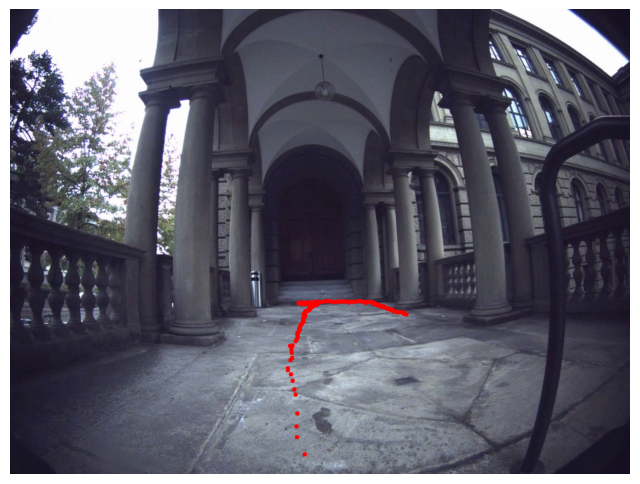

In [23]:
# print("Camera odometry shape:", odom_local.shape)
# print("First 5 odom poses:\n", odom_local[:, 1:4])
uv, mask = project_to_pixel(p_alpha_local, calib)
uv = uv[mask]
print("UV:", uv)

# Draw poitns with cv2 on image then show
import cv2
def draw_points_on_image(image, points, color=(0, 255, 0), radius=5):
    for i, (u, v) in enumerate(points):
        if i < 1:
            continue
        cv2.circle(image, (int(u), int(v)), radius, color, -1)
    return image

image_with_points = draw_points_on_image(frames[0].copy(), uv, color=(255, 0, 0), radius=5)
plt.figure(figsize=(8, 8))
plt.imshow(image_with_points)
plt.axis('off')
plt.show()